In [17]:
import os
import numpy as np
from custom_datagen import imageLoader
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

In [12]:
train_img_dir  = "D:/Data/input_data/train/images/"
train_mask_dir = "D:/Data/input_data/train/masks/"
val_img_dir    = "D:/Data/input_data/val/images/"
val_mask_dir   = "D:/Data/input_data/val/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

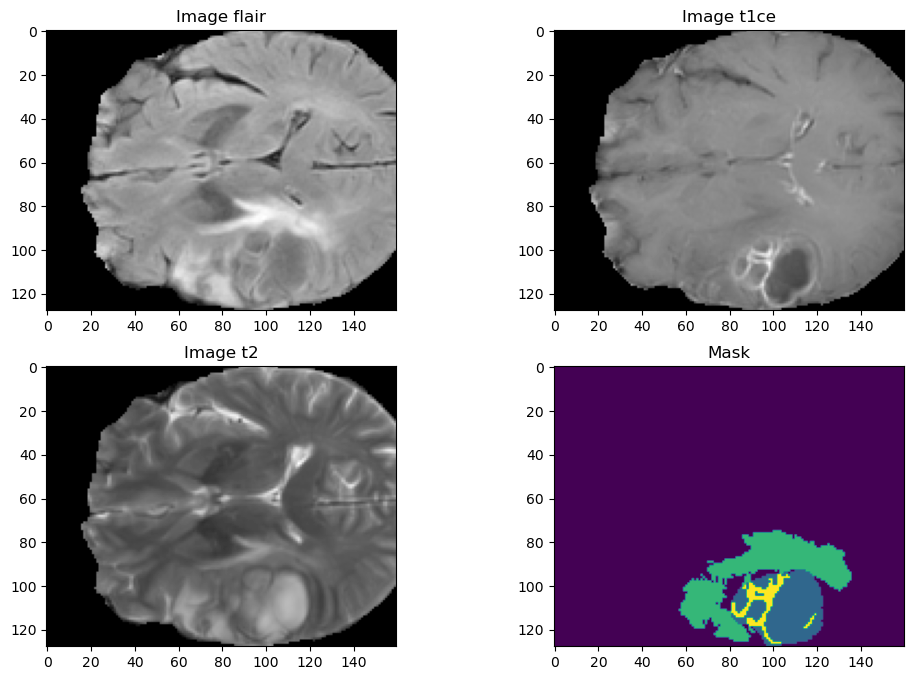

In [11]:
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=64
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# /**********

In [14]:
train_img_list  = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list    = os.listdir(val_img_dir)
val_mask_list   = os.listdir(val_mask_dir)

In [18]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


# Verify generator

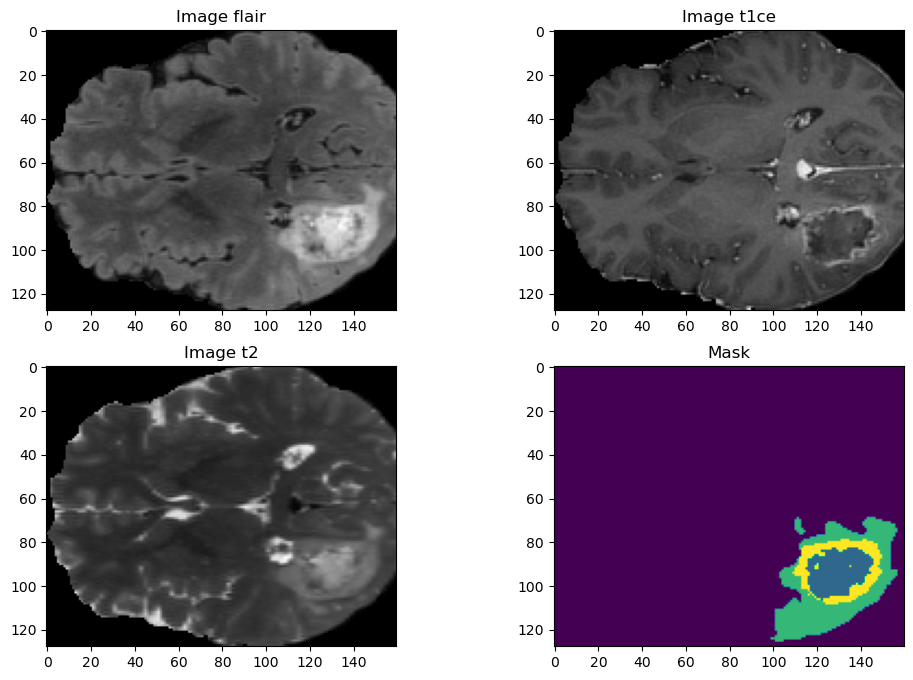

In [20]:
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# Define loss, metrics and optimizer 

In [23]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [29]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


from  simple_3d_unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=160, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 160, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_38 (Conv3D)             (None, 128, 160, 12  1312        ['input_3[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 160, 12  0           ['conv3d_38[0][0]']              
                                8, 16)                                                      

                                                                                                  
 conv3d_50 (Conv3D)             (None, 32, 40, 32,   221248      ['concatenate_9[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_24 (Dropout)           (None, 32, 40, 32,   0           ['conv3d_50[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_51 (Conv3D)             (None, 32, 40, 32,   110656      ['dropout_24[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_tr

In [30]:
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
# print(model.summary())

print(model.input_shape)
print(model.output_shape)

(None, 128, 160, 128, 3)
(None, 128, 160, 128, 4)


# Fit the model 

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=2,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('brats_3d.hdf5')

Epoch 1/100


plot the training and validation IoU and loss at each epoch


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()